# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 8. Generative Adversarial Networks

<h3 align='left'>Практическое задание:</h3>  

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики



## 0. Подготовка
Подключаем нужные модули и библиотеки

In [1]:
# import os
import numpy as np
import math
import torch
import torch.nn as nn
# import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from IPython import display
from torchvision.utils import save_image, make_grid

Определим нужное нам устройство:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Dataset

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        # return torch.FloatTensor([point, self.func(point)])
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

### Function

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10

In [5]:
MIN = -15
MAX = 15
NUM = 10000

In [6]:
data = Data(FUNC, MIN, MAX, NUM)
data[0]

tensor([12.1963, -1.2493])

## 2. DataLoader

In [7]:
data_loader = DataLoader(data, batch_size = 1000, shuffle=True)

## 3. Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

## 4. Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear_3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x): 
    
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.linear_3(x)
        x = torch.sigmoid(x)
        return x

## 5. Training

### Initialization

In [10]:
n_epochs = 1000  # количество эпох
lr = 0.001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 1  # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64

In [11]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [12]:
d_loss_history = []
g_loss_history = []

### Learning process

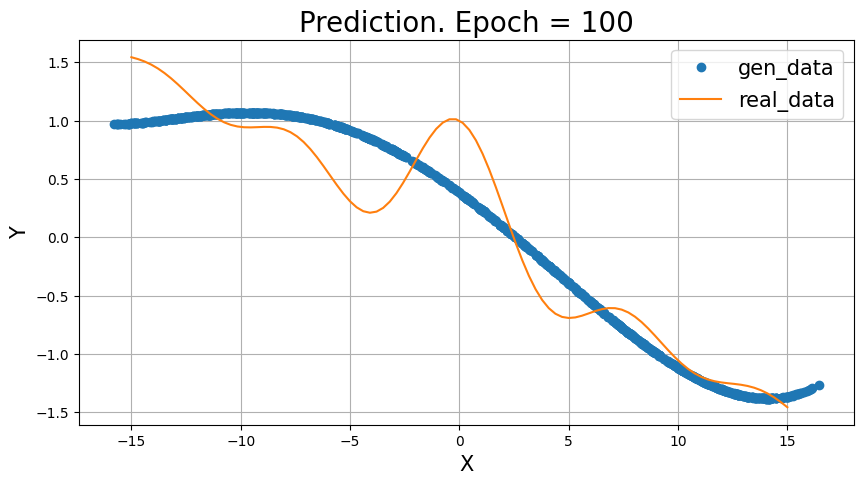

Discriminator_loss: 0.646; Generator_loss: 0.768


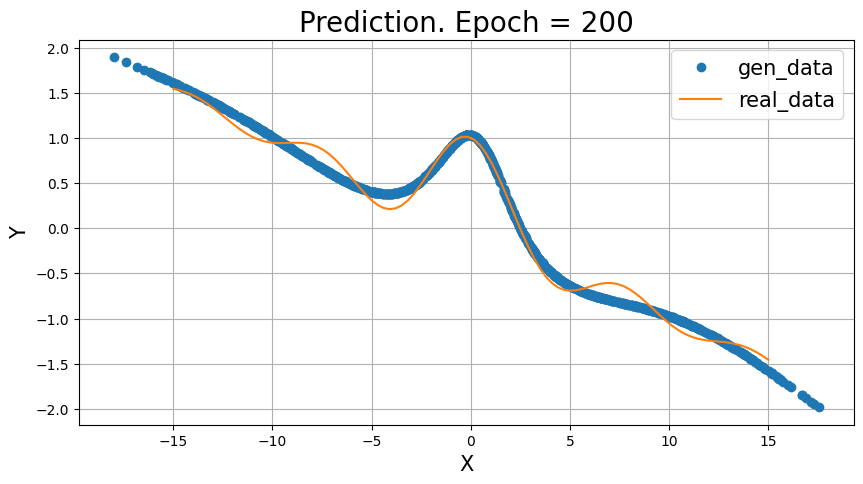

Discriminator_loss: 0.683; Generator_loss: 0.738


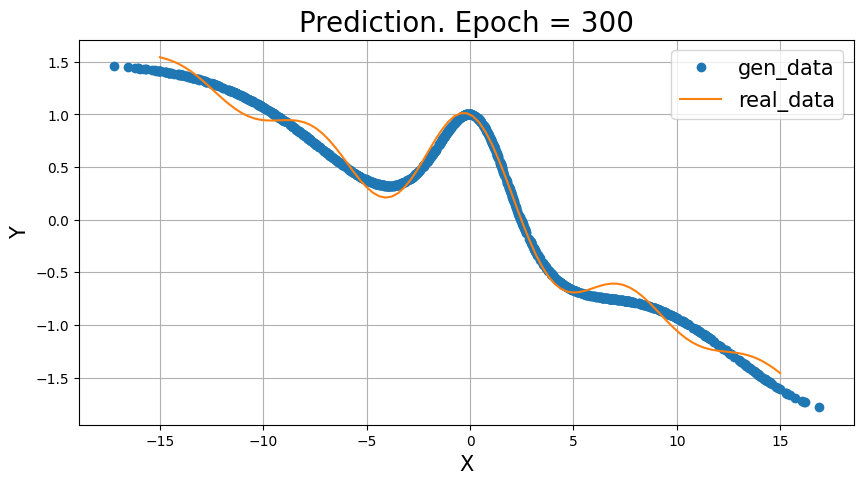

Discriminator_loss: 0.68; Generator_loss: 0.732


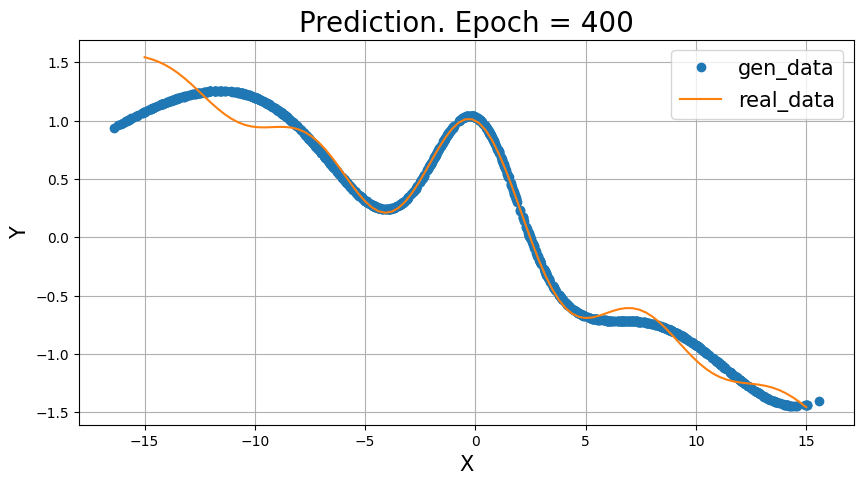

Discriminator_loss: 0.685; Generator_loss: 0.715


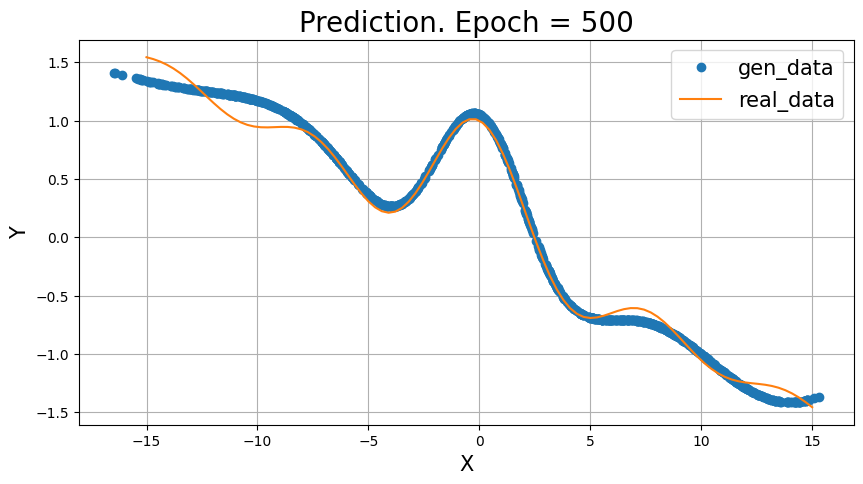

Discriminator_loss: 0.689; Generator_loss: 0.704


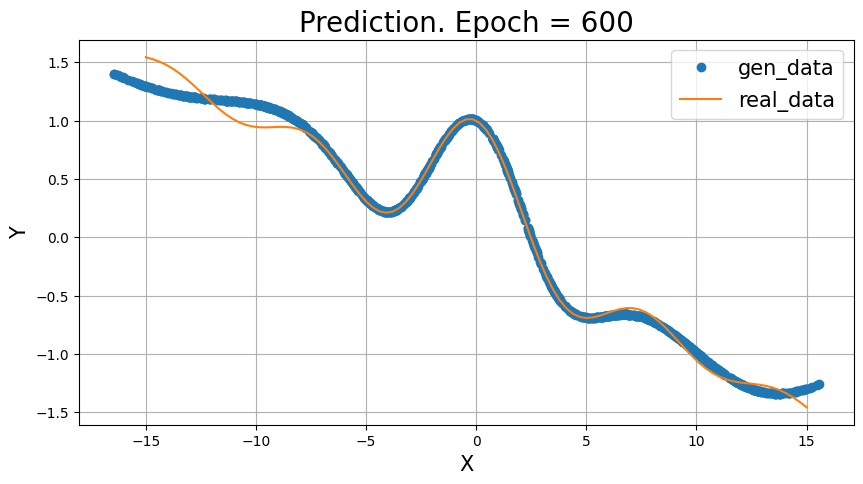

Discriminator_loss: 0.692; Generator_loss: 0.705


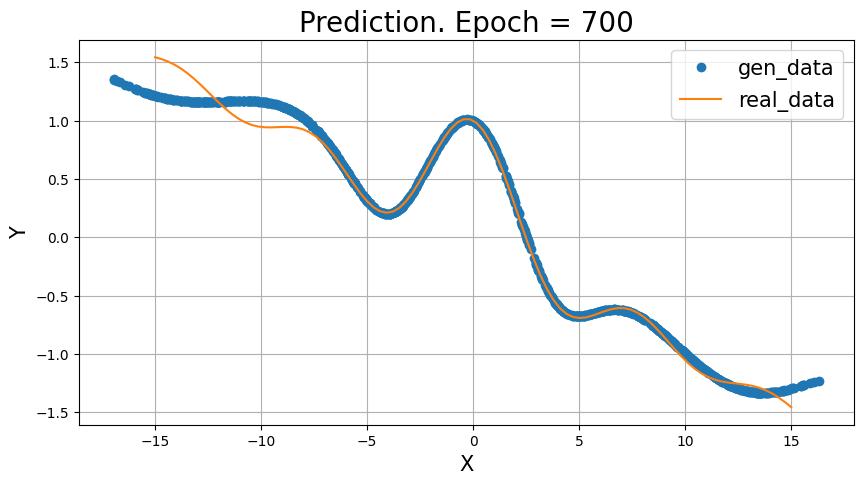

Discriminator_loss: 0.692; Generator_loss: 0.693


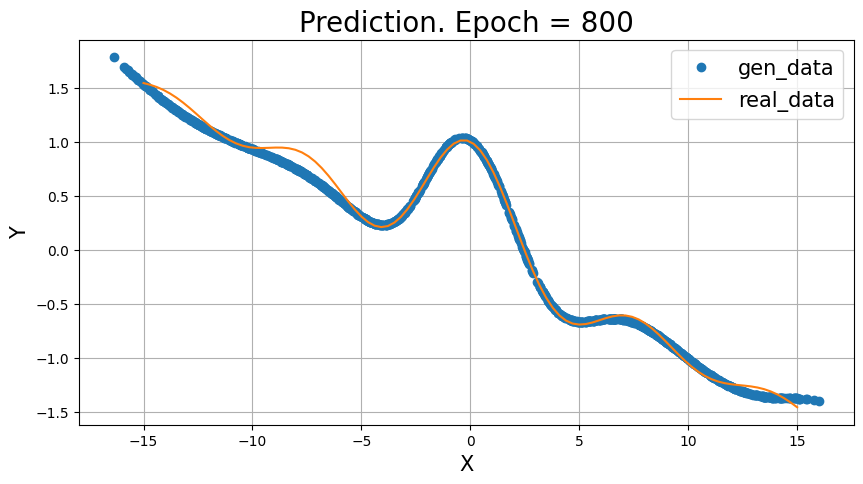

Discriminator_loss: 0.692; Generator_loss: 0.696


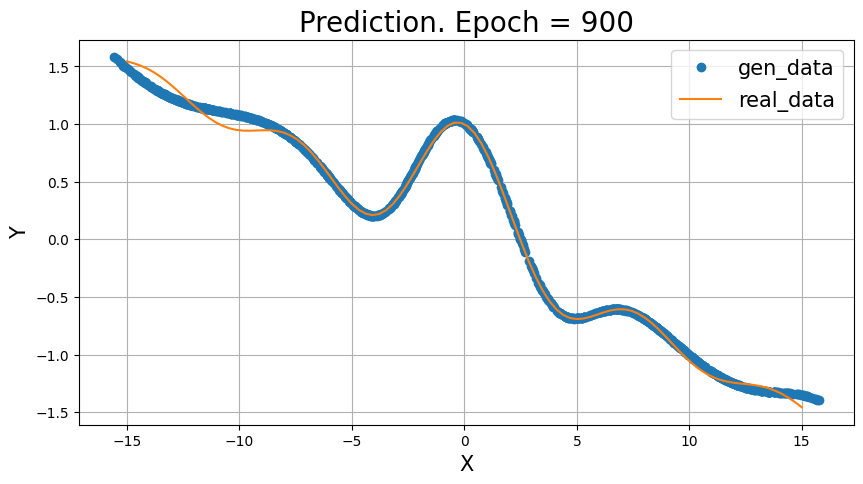

Discriminator_loss: 0.694; Generator_loss: 0.702


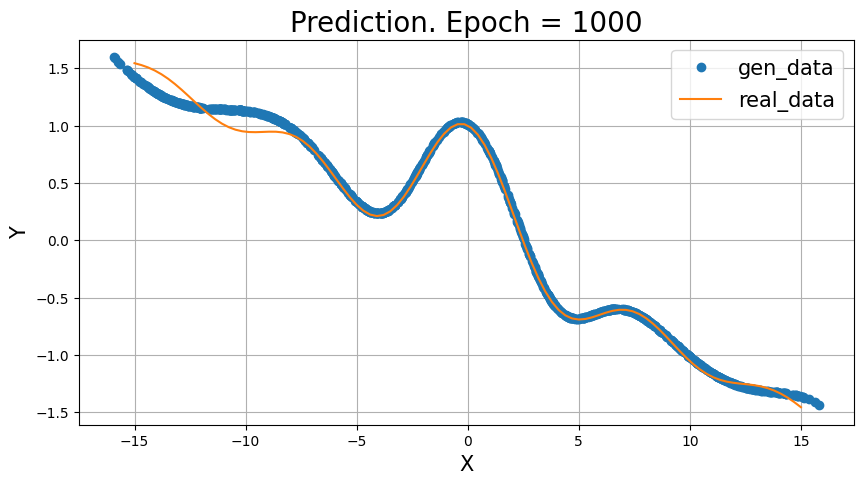

Discriminator_loss: 0.692; Generator_loss: 0.703


In [13]:
for epoch in range(1, n_epochs + 1):    

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума        
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
        
######## Отображение процесса обучения и вывод функций потерь ############
    if epoch % 100 == 0:
        
        plt.figure(figsize = (10,5))
        plt.title(f'Prediction. Epoch = {epoch}', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()
        print(f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
              f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

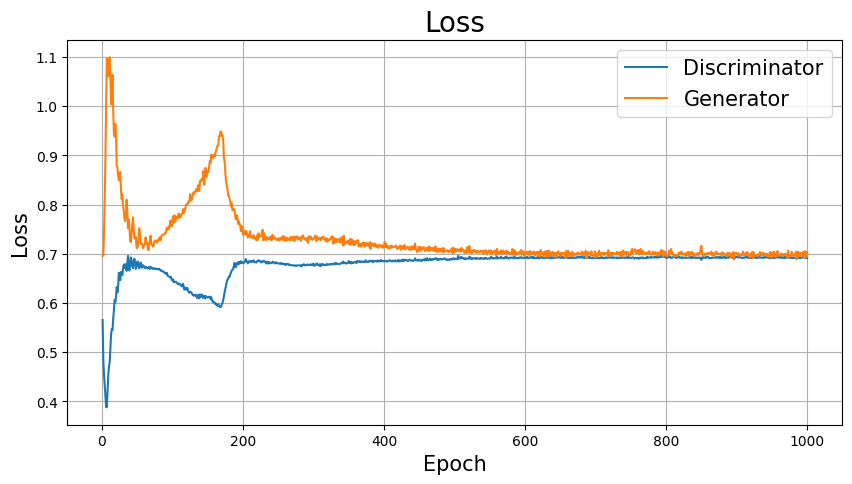

In [14]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);

## Вывод

* Discriminator - 3 слойная линейная нейронная сеть с функциями активации relu и выходной функцией sigmoid, чтобы получить вероятностную оценку от 0 до 1 для точек.

* Generator - 2 слойная линейная нейронная сеть с функцией активации tanh, так как эта функция хорошо описывает sin(x) который присутствует в реальных данных, но tanh хуже чем relu передаёт градиент, поэтому в нейронной сети всего 2 слоя. На выходе не стоит функция активации, так как в теории точка (x,y) имеет область определения от -inf до +inf для каждой координаты.

* Латентный вектор имеет размероность один, так как чтобы построить точки (x,y), где y=f(x), достаточно знать только x, а значит можно взять размерность один для латентного вектора z, ведь наш генератор может отобразить эту координату из латентного пространства на ось Х, а дальше найти y=f(x), только делая это параллельно, а не последовательно. Таким образом теоретически понятно, что для латентного вектора достаточно размерности один. Так же можно заметить, что при такой размерности латентного вектора распределение точек сразу принимает форму какой-то кривой, а не области, что уже является правильным, а значит брать большую размерность для латентного вектора неэффективно.

* Как можно увидеть на графиках, на первых 200 эпохах идёт активное обучение генератора, дальше можно заметить, что генератору не удаётся построить только краевые точки. Это связано с тем, что при обучении генератора мы подаём ему на вход нормальное распределение, а значит генератор гораздо чаще строит точки в середине и гораздо реже краевые точки, соответственно реже на них ошибается и реже настраивает для них веса, зато он почти не ошибается для точек в центре.